LSTM model Prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#np.set_printoptions(threshold=np.inf)

Load DataSet

In [70]:
df = pd.read_csv('../../Data/testData_2019_2021.csv',index_col=0)
df = df.drop(['nextDay_prediction'], axis=1)
df


,Open,High,Low,Close,Volume,change (%),change in next day (%),NewsCount,Sentiment
Date,,,,,,,,,
2019/01/01,3746.713379,3850.913818,3707.231201,3843.520020,4.324201e+09,2.584,2.447,11,-1
2019/01/02,3849.216309,3947.981201,3817.409424,3943.409424,5.244857e+09,2.447,-2.399,35,0
2019/01/03,3931.048584,3935.685059,3826.222900,3836.741211,4.530215e+09,-2.399,0.670,51,13
2019/01/04,3832.040039,3865.934570,3783.853760,3857.717529,4.847965e+09,0.670,-0.176,29,3
2019/01/05,3851.973877,3904.903076,3836.900146,3845.194580,5.137610e+09,-0.176,6.259,17,4
...,...,...,...,...,...,...,...,...,...
2021/12/27,50802.609380,51956.328130,50499.468750,50640.417970,2.432435e+10,-0.319,-6.099,139,35
2021/12/28,50679.859380,50679.859380,47414.210940,47588.855470,3.343038e+10,-6.099,-2.476,170,36
2021/12/29,47623.871090,48119.742190,46201.496090,46444.710940,3.004923e+10,-2.476,1.479,163,31


DataSet Scalling

In [71]:
dataset = df
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print('dataset.shape', dataset.shape)
num_of_features = len(df.columns)
print('Number of features', num_of_features)

dataset.shape (1096, 9)
Number of features 9


In [63]:
dataset

array([[0.00538341, 0.0064712 , 0.00501988, ..., 0.70795226, 0.04020101,
        0.28712872],
       [0.00698131, 0.00795628, 0.00676899, ..., 0.62139183, 0.16080402,
        0.2970297 ],
       [0.00825699, 0.00776815, 0.00690891, ..., 0.67621106, 0.24120604,
        0.42574257],
       ...,
       [0.68937844, 0.6837615 , 0.67962795, ..., 0.6906616 , 0.8040201 ,
        0.6039604 ],
       [0.6717121 , 0.680093  , 0.67738664, ..., 0.6315733 , 0.65829146,
        0.51485145],
       [0.6822933 , 0.6891589 , 0.6735709 , ..., 0.71727633, 0.7336683 ,
        0.7326733 ]], dtype=float32)

Configuration

In [94]:
expr_name = 'expr_1'
look_back = 290 # 60 days 
lstm_layers = 32
epochs=5
batch_size=4

In [78]:
pred_col = df.columns.get_loc('change in next day (%)')
pred_col

6

spliting datasets into train and test

In [95]:
train_size_percent = 0.70
pred_col = df.columns.get_loc('change in next day (%)')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    # print(a)
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  767
Testing dataset length  329
look_back  290


Build the model and train

In [96]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/5
84/84 [==============================] - 6s 51ms/step - loss: 0.0218 - val_loss: 0.0055
Epoch 2/5
84/84 [==============================] - 4s 47ms/step - loss: 0.0053 - val_loss: 0.0071
Epoch 3/5
84/84 [==============================] - 4s 46ms/step - loss: 0.0052 - val_loss: 0.0082
Epoch 4/5
84/84 [==============================] - 4s 47ms/step - loss: 0.0052 - val_loss: 0.0091
Epoch 5/5
84/84 [==============================] - 4s 47ms/step - loss: 0.0052 - val_loss: 0.0103


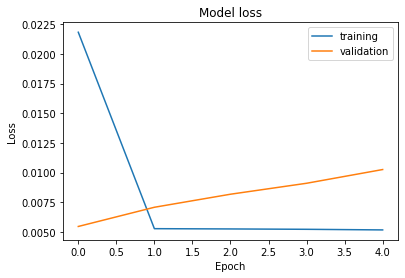

In [97]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [98]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

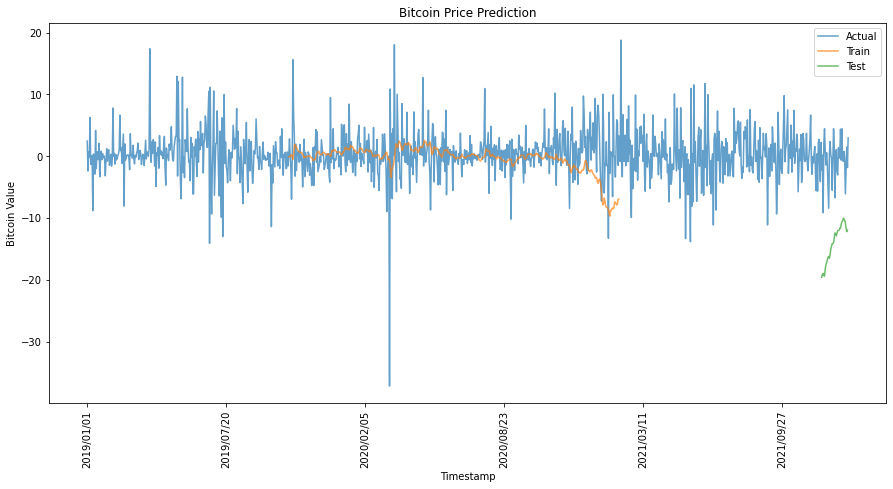

In [99]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# sshift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('Date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [45]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_1
--------------------------------------------------
look_back days: 2.5
lstm_layers: 32
epochs: 5
batch_size: 128
dataset features ['Open', 'High', 'Low', 'Close', 'Volume', 'change (%)', 'change in next day (%)', 'NewsCount', 'Sentiment', 'nextDay_prediction']
--------------------------------------------------
Train Score: 6.09 RMSE
Test Score: 4.97 RMSE
--------------------------------------------------
Train Score: 5.06 MAE
Test Score: 4.38 MAE
--------------------------------------------------
Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                          